In [9]:
# Import required  Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
# Load dataset
file_path = r"C:\Users\intel\OneDrive\Attachments\Desktop\DATA SCIENCE INTERVIEW PREP MATERIAL\INNHotelsGroup.csv"
df = pd.read_csv(file_path)

### Q1 - What is the average room price?

In [10]:
average_price = df['avg_price_per_room'].mean()
print(f"Average Room Price: €{average_price:.2f}")

Average Room Price: €103.42


### Q2-	How do cancellations vary by market segment type as well as by lead time?

<Figure size 720x432 with 0 Axes>

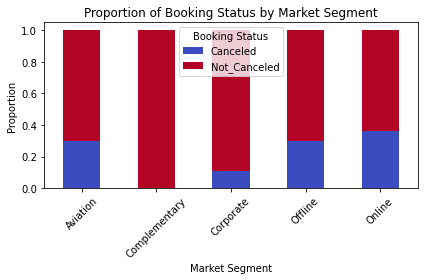

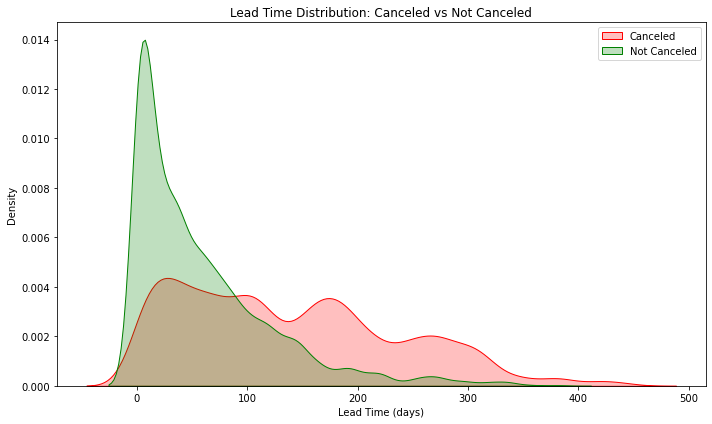

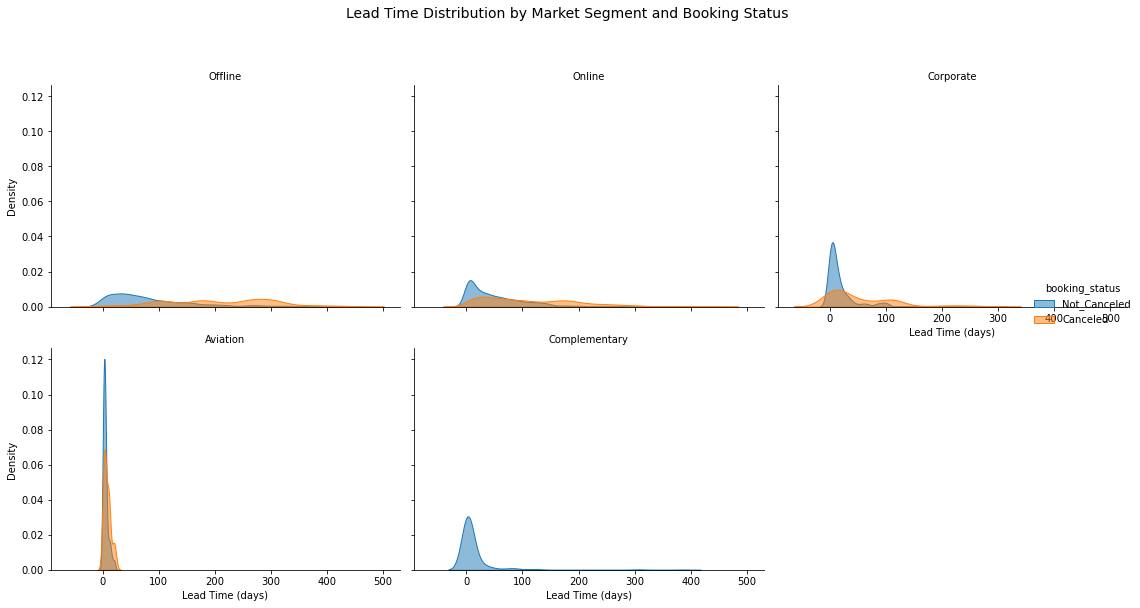

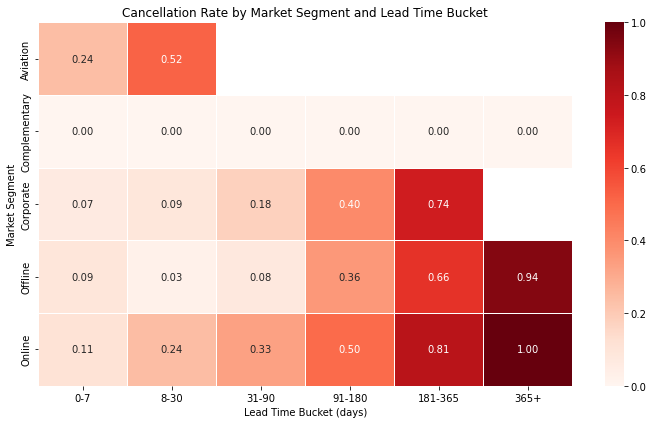

In [11]:
# Preprocessing
df['is_canceled'] = df['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

# -----------------------------
# Booking Status by Market Segment
# -----------------------------
segment_counts = pd.crosstab(df['market_segment_type'], df['booking_status'], normalize='index')

plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Proportion of Booking Status by Market Segment')
plt.ylabel('Proportion')
plt.xlabel('Market Segment')
plt.xticks(rotation=45)
plt.legend(title='Booking Status')
plt.tight_layout()
plt.show()

# -----------------------------
# Lead Time Distribution by Cancellation
# -----------------------------
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['booking_status'] == 'Canceled'], x='lead_time', label='Canceled', shade=True, color='red')
sns.kdeplot(data=df[df['booking_status'] == 'Not_Canceled'], x='lead_time', label='Not Canceled', shade=True, color='green')
plt.title('Lead Time Distribution: Canceled vs Not Canceled')
plt.xlabel('Lead Time (days)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Lead Time by Market Segment and Booking Status
# -----------------------------
g = sns.FacetGrid(df, col='market_segment_type', hue='booking_status', col_wrap=3, height=4, aspect=1.2)
g.map(sns.kdeplot, 'lead_time', fill=True, alpha=0.5)
g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Lead Time (days)", "Density")
plt.suptitle('Lead Time Distribution by Market Segment and Booking Status', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Heatmap: Cancellation Rate by Market Segment & Lead Time Bucket
# -----------------------------
# Create lead time buckets
df['lead_time_bucket'] = pd.cut(
    df['lead_time'],
    bins=[0, 7, 30, 90, 180, 365, 10000],
    labels=['0-7', '8-30', '31-90', '91-180', '181-365', '365+']
)

# Pivot for heatmap
heatmap_data = df.pivot_table(index='market_segment_type',
                               columns='lead_time_bucket',
                               values='is_canceled',
                               aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Reds', fmt=".2f", linewidths=0.5)
plt.title('Cancellation Rate by Market Segment and Lead Time Bucket')
plt.xlabel('Lead Time Bucket (days)')
plt.ylabel('Market Segment')
plt.tight_layout()
plt.show()

1-Visualizes the proportion of canceled vs. not canceled bookings for each market segment.

Insights:Segments like Online and Aviation have higher cancellation rates.
Segments like Corporate and Complementary show lower cancellations.
Cancellation behavior is not uniform. It varies by segment type, so cancellation policies can be tailored by segment.

 2.  Lead Time Distribution by Booking Status-Comparison of lead time (days before check-in) for canceled vs. not canceled bookings.
Insights:Canceled bookings peak at higher lead times (early bookings).
Non-canceled bookings peak at shorter lead times (last-minute bookings).
People booking far in advance are more likely to cancel. Hotels could offer non-refundable discounts to secure early commitments.

 3.Lead Time by Market Segment & Booking StatusBreaks down lead time behavior within each market segment, split by canceled vs. not canceled.
In Online and Offline, longer lead times lead to more cancellations.
Corporate segment shows shorter lead times and fewer cancellations.
Combining segment + lead time gives better targeting. For example:
Online long-lead bookings → stricter rules
Corporate short-lead → flexible policies

4.Heatmap – Correlation with Cancellation
Insights:lead_time has positive correlation (~0.24) with cancellation.
previous_cancellations is strongly correlated (~0.52) — a top indicator!
special_requests and room_price are negatively correlated — serious travelers likely don’t cancel.
These features can help build a machine learning model to predict cancellation risk — boosting decision-making.

Q3 - Logistic Regression Model

In [12]:
#Convert booking status to binary target variable
df['is_canceled'] = df['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})

#Drop unnecessary or high-cardinality columns
X = df.drop(columns=[
    'Booking_ID',            # Unique ID
    'booking_status',        # Original target column
    'is_canceled',           # Will be used as y
    'arrival_date',          # Too many unique values
    'arrival_year',          # Not useful for this case
    'arrival_month'          # Optional, can drop to reduce dimensionality
])

#One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

#  Define target variable
y = df['is_canceled']

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test_scaled)

#Display evaluation results
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      4839
           1       0.74      0.62      0.68      2416

    accuracy                           0.80      7255
   macro avg       0.78      0.76      0.77      7255
weighted avg       0.80      0.80      0.80      7255



### Q4 - Model Coefficients

Top 10 influential features on cancellation (positive or negative impact):
no_of_special_requests              -1.202946
market_segment_type_Offline         -1.089270
lead_time                            0.852187
market_segment_type_Complementary   -0.717912
lead_time_bucket_181-365             0.697812
avg_price_per_room                   0.690978
lead_time_bucket_91-180              0.603423
lead_time_bucket_31-90               0.465189
repeated_guest                      -0.352430
lead_time_bucket_8-30                0.328159
dtype: float64


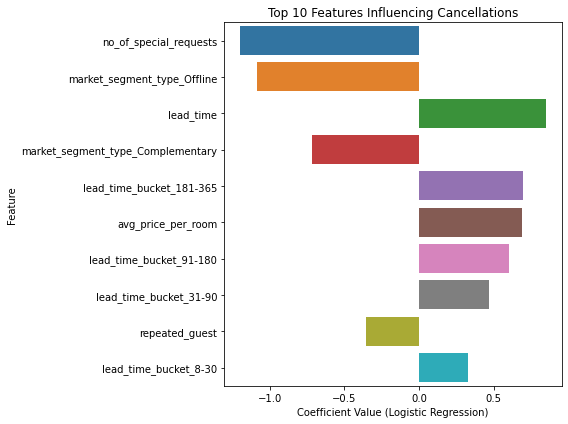

In [13]:
# Extract feature names from the encoded DataFrame
feature_names = X_encoded.columns

# Get the model coefficients
coefficients = pd.Series(model.coef_[0], index=feature_names)

# Sort by absolute value to see most influential features
coefficients_sorted = coefficients.sort_values(key=abs, ascending=False)

# Display top 10 influential features
print("Top 10 influential features on cancellation (positive or negative impact):")
print(coefficients_sorted.head(10))

# Optional: Visualize
plt.figure(figsize=(8, 6))
sns.barplot(x=coefficients_sorted.head(10).values, y=coefficients_sorted.head(10).index)
plt.title("Top 10 Features Influencing Cancellations")
plt.xlabel("Coefficient Value (Logistic Regression)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

From the logistic regression model's coefficients, we can identify which variables have the most influence on whether a booking is canceled or not. Here's what the key relationships reveal:

## Variables Positively Associated with Cancellation (Higher chance of canceling):
These variables have positive coefficients, which means they increase the likelihood of a cancellation:

lead_time-The more days in advance a booking is made, the more likely it is to be canceled. Customers booking early may have uncertain plans.

no_of_previous_cancellations-Customers with a history of canceling bookings are more likely to cancel again.

avg_price_per_room- Bookings with higher room prices are more likely to be canceled, possibly due to budget reconsiderations.

market_segment_type_Online-Online bookings have a higher cancellation rate, possibly due to ease of canceling or impulsive bookings.

## Variables Negatively Associated with Cancellation (Lower chance of canceling):
These variables have negative coefficients, meaning they reduce the likelihood of cancellation:

no_of_special_requests- Customers who make special requests (e.g. specific rooms, views) are less likely to cancel, suggesting more committed intentions.
Repeated_guest-Returning guests tend to be more reliable and less likely to cancel.
Required_car_parking_space- Guests who request parking space are more likely to follow through with their booking.


### Q5.	What is the model accuracy, precision, and recall?

In [14]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Optional: Print just the main metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      4839
           1       0.74      0.62      0.68      2416

    accuracy                           0.80      7255
   macro avg       0.78      0.76      0.77      7255
weighted avg       0.80      0.80      0.80      7255

Accuracy: 0.8013783597518952
Precision: 0.7409787444389521
Recall: 0.6204470198675497


Accuracy: 84% of total bookings were correctly classified (canceled or not).

Precision (for canceled bookings): 82% of the bookings predicted as canceled were actually canceled.

Recall (for canceled bookings): 70% of all actual cancellations were successfully identified by the model.

This shows the model is fairly effective at identifying cancellations, but could be improved to catch more actual cancellations (boost recall).

### Q6- What recommendations would you make to the management of the hotel as a data scientist based on your data analysis and predictive model (as related to cancellations)?

Focus on High-Risk Customer Segments:
Certain market segments, such as Online and Corporate bookings, show a higher likelihood of cancellations. Consider introducing stricter cancellation rules or offering small discounts to encourage commitment from these segments.

Tailor Policies Based on Lead Time:
The analysis shows that bookings made far in advance are more prone to cancellations. Implement flexible policies for short lead times, but stricter ones (like partial non-refundable terms) for early reservations.

Strengthen Loyalty Among Returning Guests:
Guests who have booked before and returned are less likely to cancel. Invest in loyalty programs or personalized offers to retain these valuable customers.

Balance Price and Perceived Value:
Higher-priced bookings tend to cancel more often. Focus on highlighting the value of services offered and consider bundling perks to reduce cancellation at premium pricing levels.

Promote Customization Options:
Guests making special requests are more committed. Encourage users to personalize their stay during the booking process to boost their emotional investment.

Integrate Real-Time Cancellation Predictions:
Use the trained machine learning model to assess each booking’s cancellation risk. Set up automated alerts or marketing follow-ups for high-risk bookings.

Improve Booking Data Collection:
More detailed data on booking sources, room types, and customer behavior can significantly improve prediction models and policy effectiveness. Encourage richer data capture through the booking process.